<a href="https://colab.research.google.com/github/syedabusafwan/syedabusafwan/blob/practice/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preparation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
!pip install -q kaggle


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list





cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 46% 7.00M/15.1M [00:00<00:00, 71.8MB/s]
100% 15.1M/15.1M [00:00<00:00, 98.2MB/s]


In [5]:
!mkdir train


In [6]:
!unzip '/content/brain-mri-images-for-brain-tumor-detection.zip' -d '/content/train'

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: /content/train/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/train/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/19 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/2 no.jpeg  
  inflating: /content/train/brain_tumor_dataset/no/20 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/21 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/22 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/2

In [7]:
#deta preparation
folder = '/content/train/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [8]:
folder = '/content/train/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


**EDA**

In [9]:
listyes = os.listdir('/content/train/brain_tumor_dataset/yes/')
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir('/content/train/brain_tumor_dataset/no/')
number_files_no = len(listno)
print(number_files_no)

155
98


In [10]:
#PLOT

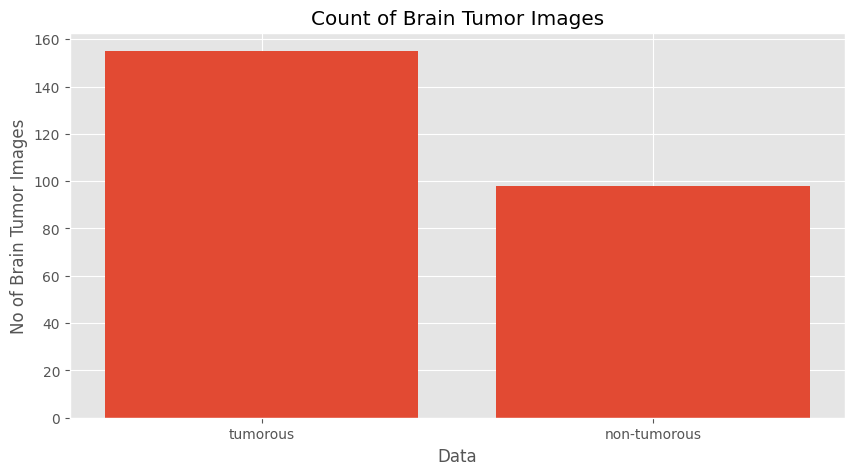

In [11]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize = (10,5))
plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

**Data Augmentation**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


USE IT if NEEDED
def clear_directory(directory):
    """Remove all files in the directory."""
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and all its contents
    os.makedirs(directory)  # Recreate an empty directory

clear_directory('/content/train/no')

In [13]:
if not os.path.isdir('/content/train/augmented_data'):
  os.mkdir('/content/train/augmented_data')

In [14]:
if not os.path.isdir('/content/train/augmented_data/yes'):
  os.mkdir('/content/train/augmented_data/yes')
if not os.path.isdir('/content/train/augmented_data/no'):
  os.mkdir('/content/train/augmented_data/no')

In [15]:
def timing(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60) / 60))
  s = sec_elapsed % 60

  return f"{h}:{m}:{s}"

In [16]:
def augmented_data(file_dir, n_genarated_samples, save_to_dir):
  data_gen = ImageDataGenerator(rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    image = image.reshape((1,) + image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i=0
    for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
      i += 1
      if i>n_genarated_samples:
        break


In [17]:
def augmented_data(file_dir, n_genarated_samples, save_to_dir):
  data_gen = ImageDataGenerator(rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    # Call the reshape method with the correct dimensions. Assuming you want to add a dimension at the beginning:
    image = image.reshape((1,) + image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i=0
    for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
      i += 1
      if i>n_genarated_samples:
        break

In [18]:
import time
start_time = time.time()

yes_path = '/content/train/brain_tumor_dataset/yes'
no_path = '/content/train/brain_tumor_dataset/no'

augmented_data_path = '/content/train/augmented_data/'

augmented_data(file_dir = yes_path, n_genarated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir = no_path, n_genarated_samples=9, save_to_dir=augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time + start_time
print(timing(execution_time))

959722:37:36.92726373672485


In [19]:
def data_summary(main_path):
  yes_path = '/content/train/augmented_data/yes'
  no_path = '/content/train/augmented_data/no'

  n_pos = len(os.listdir(yes_path))
  n_neg = len(os.listdir(no_path))

  n = n_pos + n_neg

  pos_per = (n_pos*100)/n
  neg_per = (n_neg*100)/n

  print(f"Number of sample{n}")
  print(f"{n_pos} Percentage of Positive:{pos_per}")
  print(f"{n_neg} Percentage of Negative:{neg_per}")

In [20]:
data_summary(augmented_data_path)

Number of sample2064
1085 Percentage of Positive:52.56782945736434
979 Percentage of Negative:47.43217054263566


In [21]:
listyes = os.listdir('/content/train/augmented_data/yes/')
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir('/content/train/augmented_data/no/')
number_files_no = len(listno)
print(number_files_no)

1085
979


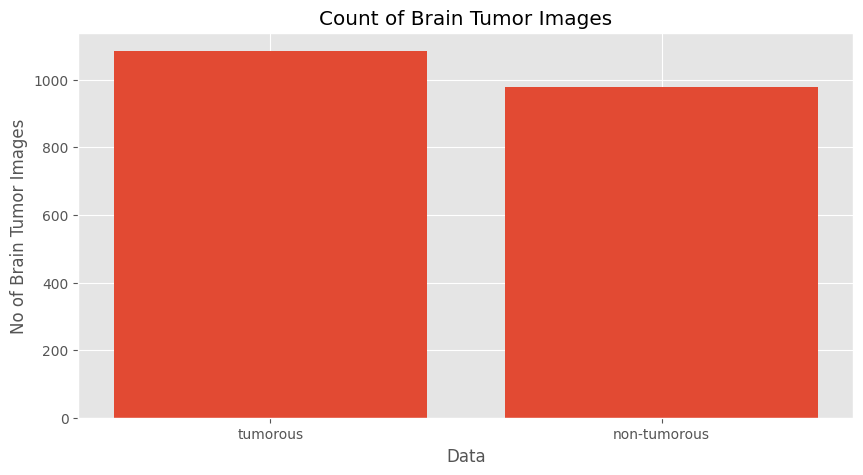

In [22]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize = (10,5))
plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

**Data Preprocessing**

In [23]:
# convert BGR to GRAY
# GauaainBlur
# Threshold - The threshold value is set to 45, meaning pixels with
#            intensities above 45 will be set to 255 (white), and pixels
#            below 45 will be set to 0 (black).
# Erode - Erosion removes pixels along the boundaries of objects,
#         making them smaller.
# Dilate - Dilation adds pixels to the boundaries of objects,
#          making them larger.
# Find Contours

In [24]:
!pip install opencv-python
!pip install matplotlib

import cv2
import imutils
from matplotlib import pyplot as plt
import numpy as np # Added import for NumPy


def crop_brain_tumor(image, plot=False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)

  thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thres = cv2.erode(thres, None, iterations=2)
  thres = cv2.dilate(thres, None, iterations=2)

  cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key = cv2.contourArea)

  # Corrected the slicing of the NumPy array
  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0])
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])

  # Changed img to image
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Croped Image')
    plt.show()
  return new_image

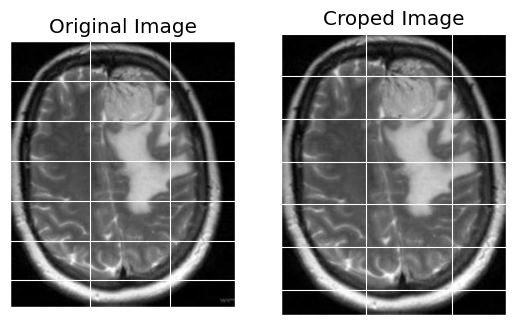

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [3, 3, 3]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [3, 3, 3]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [3, 3, 3]]], dtype=uint8)
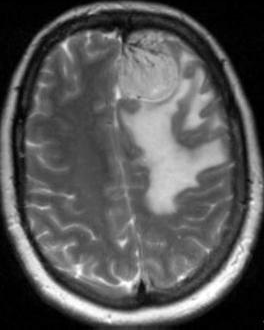

In [26]:
img = cv2.imread('/content/train/augmented_data/yes/aug_Y_100_0_114.jpg')
crop_brain_tumor(img, True)

In [27]:
folder1 = '/content/train/augmented_data/no/'
folder2 = '/content/train/augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [28]:
folder1 = '/content/train/augmented_data/no/'
folder2 = '/content/train/augmented_data/yes/'

for filename in os.listdir(folder1):
  img = cv2.imread(folder1 + filename)
  img = crop_brain_tumor(image=img, plot=False)
  cv2.imwrite(folder1 + filename, img)

for filename in os.listdir(folder2):
  img = cv2.imread(folder2 + filename)
  img = crop_brain_tumor(image=img, plot=False)
  cv2.imwrite(folder2 + filename, img)


In [29]:
#image Loading

In [30]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
  X = []
  y = []

  image_width, image_height = image_size

  for directory in dir_list:
    for filename in os.listdir(directory):
      image = cv2.imread(directory + '/' + filename)
      image = crop_brain_tumor(image, plot=False)
      image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
      image = image / 255.00
      X.append(image)
      if directory[-3:] == 'yes':
        y.append([1])
      else:
        y.append([0])

  # Moved the return statement outside the loop to process all directories
  X = np.array(X)
  y = np.array(y)

  X,y = shuffle(X,y)
  print(f"Number of examples is:{len(X)}")
  print(f"X shape is:{X.shape}")
  print(f"y shape is:{y.shape}")

  return X, y

In [31]:
augmented_path = '/content/train/augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240,240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is:2064
X shape is:(2064, 240, 240, 3)
y shape is:(2064, 1)


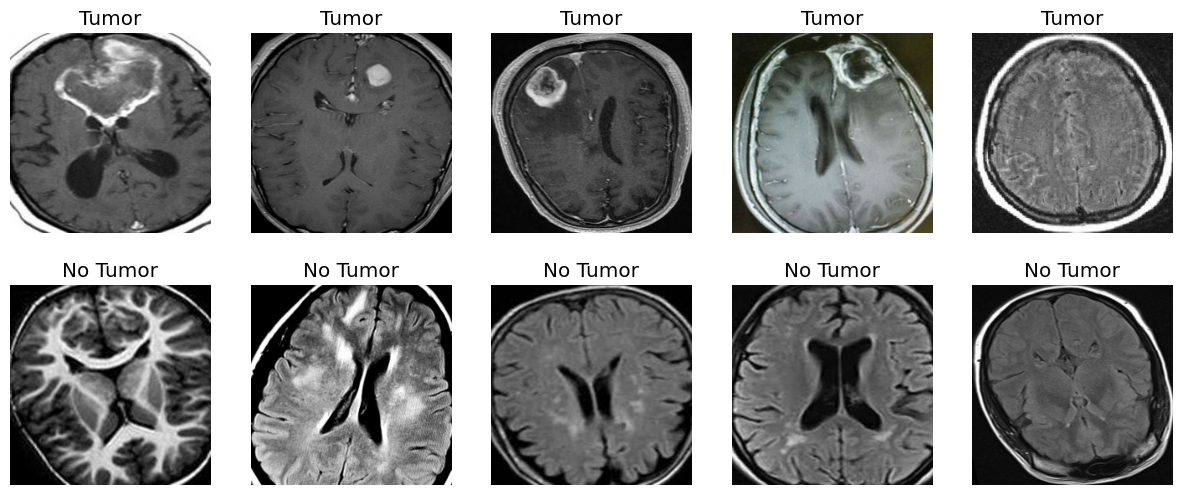

In [32]:
# prompt: plot sample images tumor non tumor 10 samples with easy code

import matplotlib.pyplot as plt

# Assuming X and y are your data and labels
# Select 10 samples with tumor (y == 1)
tumor_samples = X[y.flatten() == 1][:5]
# Select 10 samples without tumor (y == 0)
no_tumor_samples = X[y.flatten() == 0][:5]

# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the tumor samples
for i, sample in enumerate(tumor_samples):
  axes[0, i].imshow(sample)
  axes[0, i].axis('off')
  axes[0, i].set_title('Tumor')

# Plot the no-tumor samples
for i, sample in enumerate(no_tumor_samples):
  axes[1, i].imshow(sample)
  axes[1, i].axis('off')
  axes[1, i].set_title('No Tumor')

plt.show()


**Data Spilitting**

In [33]:
#Train
#Test
#validation

In [34]:
if not os.path.isdir('tumorous_and_non_tumorous'):
  base_dir = 'tumorous_and_non_tumorous'
  os.mkdir(base_dir)

In [35]:
if not os.path.isdir('tumorous_and_non_tumorous/train'):
  train_dir = os.path.join(base_dir, 'train')
  os.mkdir(train_dir)

if not os.path.isdir('tumorous_and_non_tumorous/test'):
  test_dir = os.path.join(base_dir, 'test')
  os.mkdir(test_dir)

if not os.path.isdir('tumorous_and_non_tumorous/valid'):
  valid_dir = os.path.join(base_dir, 'valid')
  os.mkdir(valid_dir)

In [36]:
if not os.path.isdir('/content/tumorous_and_non_tumorous/train/tumorous'):
  infected_train_dir = os.path.join(train_dir, 'tumorous')
  os.mkdir(infected_train_dir)
if not os.path.isdir('/content/tumorous_and_non_tumorous/test/tumorous'):
  infected_test_dir = os.path.join(test_dir, 'tumorous')
  os.mkdir(infected_test_dir)
if not os.path.isdir('/content/tumorous_and_non_tumorous/valid/tumorous'):
  infected_valid_dir = os.path.join(valid_dir, 'tumorous')
  os.mkdir(infected_valid_dir)

In [37]:
if not os.path.isdir('/content/tumorous_and_non_tumorous/train/nontumorous'):
  healthy_train_dir = os.path.join(train_dir, 'nontumorous')
  os.mkdir(healthy_train_dir)
if not os.path.isdir('/content/tumorous_and_non_tumorous/test/nontumorous'):
  healthy_test_dir = os.path.join(test_dir, 'nontumorous')
  os.mkdir(healthy_test_dir)
if not os.path.isdir('/content/tumorous_and_non_tumorous/valid/nontumorous'):
  healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
  os.mkdir(healthy_valid_dir)

In [38]:
original_dataset_tumorous = os.path.join('/content/train/augmented_data/yes/')
original_dataset_nontumorous = os.path.join('/content/train/augmented_data/no/')

In [39]:
#Tumorous

In [40]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(0, 759):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_train_dir, fname)
  shutil.copyfile(src, dst)


In [41]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(759, 922):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_test_dir, fname)
  shutil.copyfile(src, dst)


In [42]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(922, 1084):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_valid_dir, fname)
  shutil.copyfile(src, dst)


In [43]:
#Non_Tumorous

In [44]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(0, 685):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(healthy_train_dir, fname)
  shutil.copyfile(src, dst)


In [45]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(685, 832):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(healthy_test_dir, fname)
  shutil.copyfile(src, dst)


In [46]:
files = os.listdir('/content/train/augmented_data/yes/')
fnames = []
for i in range(832, 980):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(healthy_valid_dir, fname)
  shutil.copyfile(src, dst)


**Model Building**

In [47]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=0.4,
                                    vertical_flip=0.4,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    width_shift_range=0.4,
                                    height_shift_range=0.4,
                                    fill_mode='nearest')

test_data_gen = ImageDataGenerator(rescale = 1./255)

valid_data_gen = ImageDataGenerator(rescale = 1./255)




In [48]:
train_generator = train_data_gen.flow_from_directory('/content/tumorous_and_non_tumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode='rgb')



Found 1444 images belonging to 2 classes.


In [49]:
test_generator = test_data_gen.flow_from_directory('/content/tumorous_and_non_tumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode='rgb')



Found 310 images belonging to 2 classes.


In [50]:
valid_generator = valid_data_gen.flow_from_directory('/content/tumorous_and_non_tumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode='rgb')



Found 310 images belonging to 2 classes.


In [51]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [52]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [53]:
base_model = VGG19(input_shape = (240, 240, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

x=base_model.output
flat= Flatten()(x)

class1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class1)
class2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [54]:
#callback
filepath = 'model.keras' # Changed the file extension to .keras
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min', patience=6)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr= 0.0001)

In [55]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'] )


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [56]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=1, callbacks=[es, cp, lrr], validation_data=valid_generator)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.5670 - loss: 0.7327 
Epoch 1: val_loss improved from inf to 0.70229, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 656s 69s/step - accuracy: 0.5646 - loss: 0.7324 - val_accuracy: 0.4806 - val_loss: 0.7023 - learning_rate: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


In [60]:
if not os.path.isdir('/content/model_weights/'):
  os.mkdir('/content/model_weights/')

# Use the correct method name 'save_weights' and add the .weights extension
model_01.save_weights(filepath="/content/model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [ ]:
#MODEL LOAD
model_01.load_weights("/content/model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

In [59]:
print(f'Validation Loss{vgg_val_eval_01[0]}')
print(f'Validation Acc{vgg_val_eval_01[1]}')
print(f'Test Loss{vgg_test_eval_01[0]}')
print(f'Test Acc{vgg_test_eval_01[1]}')

Validation Loss0.7022864818572998
Validation Acc0.48064514994621277
Test Loss0.6958408355712891
Test Acc0.5387097001075745


**Unfreezing and fine tuning**